# Final Model Training

## Import Libraries and Load Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import random

from difflib import SequenceMatcher

from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn import svm

import optuna

from lightgbm import LGBMClassifier, LGBMRanker
from catboost import CatBoostClassifier, CatBoostRanker
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from collections import Counter

from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings

In [3]:
# EDA Imports
from src.eda import null_columns_checker, column_investigator, find_unique_values, analyser_generic, tree_path_investigator
from src.eda import non_numeric_check, dimension_investigator

# FE Imports
from src.fe import indicate_nulls, fuzzy_search, dynamic_check_text, check_columns_on_query, check_columns_on_text 
from src.fe import dim_binner, check_columns_on_dim, column_dropper, add_new_features

# Feature Model Selectin Imports
from src.feature_model_selection import find_high_corr_pairs, manual_pr_draw, manual_auc_roc_draw, groupper, feature_importance

In [4]:
# Load training data
train_file_path= 'data/train.feather'
ori_train_df = pd.read_feather(train_file_path)

## Split data

In [5]:
gss = GroupShuffleSplit(test_size=0.2, random_state=42).split(ori_train_df, groups=ori_train_df['query'])
X_train_inds, X_val_inds = next(gss)

train_df = ori_train_df.iloc[X_train_inds]
X_train = train_df.loc[:, ~train_df.columns.isin(['is_relevant'])]
y_train = train_df.loc[:, train_df.columns.isin(['is_relevant'])]

#We need to keep the query fo2r later predictions
val_df = ori_train_df.iloc[X_val_inds]
X_val = val_df.loc[:, ~val_df.columns.isin(['is_relevant'])]
y_val = val_df.loc[:, val_df.columns.isin(['is_relevant'])]

## Feature Engineering

In [6]:
train_output = add_new_features(train_df, 'train')

null_check_columns:  ['alt', 'sizes', 'class']
columns_to_drop:  ['crossorigin', 'ismap', 'longdesc', 'referrerpolicy']
Successfully dropping fully Null columns!

Successfully indicating partially Null columns!

Successfully adding text-based features!

Successfully adding url-based features!

rel_feature_potential:  ['figure', 'p', 'source']
irrel_feature_potential:  ['a']
Total Data covered: 47.4%
Successfully adding first tree-path feature!

rel_feature_potential:  ['figure', 'p', 'amp-img', 'getpreference', 'readme-toc', 'treasure-overlay-spinner', 'pre', 'task-lists', 'textarea', 'app-pharmacy-layout', 'tw-wrapper', 'app-project-detail', 'bpc-app', 'ps-carousel', 'z-widget', 'bpc-product', 'brb', 'swiper', 'app-modal', 'app-photo-wall', 'object', 'cont', 'app-product', 'rs-layer', 'titles', 'app-person', 'b-container', 'enx-image', 'bpc-other-products-base', 'bpc-dynamic-view-carousel', 'bpc-product-card-base', 'bpc-product-card-image', 'app-medicine-detail', 'flo-header-layout', 

In [7]:
X_train_fe = train_output.pop(0)
val_inputs = train_output

In [8]:
val_output = add_new_features(val_df, 'val', val_inputs)
X_val_fe = val_output.pop(0)

Successfully dropping fully Null columns!

Successfully indicating partially Null columns!

Successfully adding text-based features!

Successfully adding url-based features!

Successfully adding first tree-path feature!

Successfully adding overall tree-path feature!

Successfully adding text-tag feature!

Successfully adding height-based feature!

Successfully adding sizes-based feature!

Successfully adding srcset-based feature!

Successfully adding width-based feature!

Successfully adding class-based feature!

Successfully adding style-based feature!

Successfully removing high correlated features!

Successfully reordering columns!



In [9]:
print("Missing columns from X_train_fe: ", [col for col in X_val_fe.columns if col not in X_train_fe.columns])
print("Missing columns from X_val_fe: ", [col for col in X_train_fe.columns if col not in X_val_fe.columns])

Missing columns from X_train_fe:  []
Missing columns from X_val_fe:  []


## Model Training

### Light Gradient-Boosting Machine

In [10]:
def objective_lgbm(trial, X, y, kfold_group):
    # Define hyperparameters to tune (these are for LightGBM, modify as needed for different models)
    hyperparams = {
        'objective': 'lambdarank',
        'metric': 'auc',
        'eval_at': [1, 10, 20, 30],
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.2),
        'num_iterations': trial.suggest_int('num_iterations', 50, 200), 
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'tree_learner': trial.suggest_categorical('tree_learner', ['serial', 'feature', 'data', 'voting']),
        'verbose': -1,
    }

    # Initialize GroupKFold
    group_kfold = GroupKFold(n_splits=4)
    scores = []

    # Split the data and perform training and evaluation
    for train_index, val_index in group_kfold.split(X, y, kfold_group):
        X_train_, X_val_ = X.iloc[train_index], X.iloc[val_index]
        y_train_, y_val_ = y.iloc[train_index], y.iloc[val_index]

        # Initialize and train the model
        model = LGBMRanker(**hyperparams)
        model.fit(X_train_, y_train_, group=groupper(train_index))  # Adjust for non-ranking models
        
        # Predictions and evaluation for each fold
        y_pred = model.predict(X_val_)
        score = roc_auc_score(y_val_, y_pred)
        scores.append(score)

    # Return the average score across all folds
    return np.mean(scores)

X = X_train_fe
y = y_train
le = LabelEncoder()
kfold_group = le.fit_transform(train_df['query'])

with warnings.catch_warnings(record=True) as captured_warnings:
    warnings.simplefilter("always")
    
    # Start the Optuna study
    lgbm_study = optuna.create_study(direction="maximize")
    lgbm_study.optimize(lambda trial: objective_lgbm(trial, X, y, kfold_group), n_trials=3)

lgbm_best_params = lgbm_study.best_trial.params
print(f'Best parameters: {lgbm_best_params}')

[I 2024-03-15 09:06:54,954] A new study created in memory with name: no-name-24cad854-ebf3-43a1-8f89-1751140ed360
[I 2024-03-15 09:06:57,977] Trial 0 finished with value: 0.5 and parameters: {'learning_rate': 0.11402601368363136, 'num_iterations': 67, 'num_leaves': 29, 'tree_learner': 'serial'}. Best is trial 0 with value: 0.5.
[I 2024-03-15 09:07:00,408] Trial 1 finished with value: 0.5 and parameters: {'learning_rate': 0.1561711162022143, 'num_iterations': 69, 'num_leaves': 36, 'tree_learner': 'feature'}. Best is trial 0 with value: 0.5.
[I 2024-03-15 09:07:03,445] Trial 2 finished with value: 0.5 and parameters: {'learning_rate': 0.19767501779581598, 'num_iterations': 95, 'num_leaves': 40, 'tree_learner': 'feature'}. Best is trial 0 with value: 0.5.


Best parameters: {'learning_rate': 0.11402601368363136, 'num_iterations': 67, 'num_leaves': 29, 'tree_learner': 'serial'}


/Users/jeffersonqiu/Desktop/Interviews/post_riot/ahrefs/ahrefs_env/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 64
[LightGBM] [Info] Number of data points in the train set: 485297, number of used features: 32


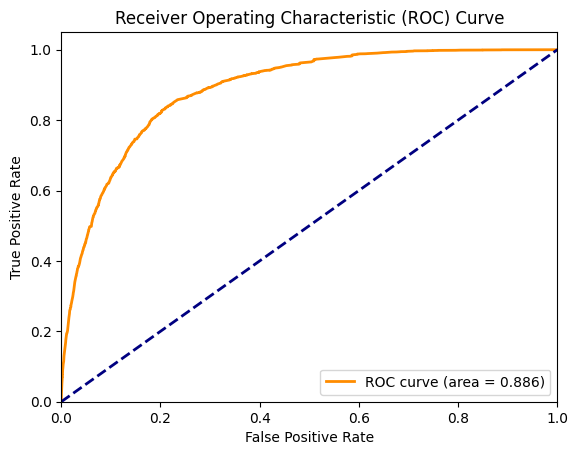

In [11]:
lgbm_model = LGBMRanker(**lgbm_best_params)
train_groups = X_train.groupby('query').size().to_frame('size')['size'].to_numpy()
lgbm_model.fit(X_train_fe, y_train, group=train_groups)

lgbm_y_pred_proba = lgbm_model.predict(X_val_fe)
proba_to_predict = lambda proba, threshold=0.5: (proba > threshold).astype(int)
lgbm_y_pred = proba_to_predict(lgbm_y_pred_proba)

manual_auc_roc_draw(y_val, lgbm_y_pred_proba)

### CatBoost Classifier

In [12]:
def objective_cb(trial, X, y):
    # Define hyperparameters to tune (these are for LightGBM, modify as needed for different models)
    hyperparams = {
        'verbose': 0,
        'learning_rate': trial.suggest_float("learning_rate", 0.1, 0.2),
        'depth': trial.suggest_int("depth", 6, 10),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 0.1, 10),
    }

    # Initialize GroupKFold
    group_kfold = GroupKFold(n_splits=4)
    scores = []

    # Split the data and perform training and evaluation
    for train_index, val_index in group_kfold.split(X, y, kfold_group):
        X_train_, X_val_ = X.iloc[train_index], X.iloc[val_index]
        y_train_, y_val_ = y.iloc[train_index], y.iloc[val_index]

        # Initialize and train the model
        model = CatBoostClassifier(**hyperparams)
        model.fit(X_train_, y_train_)  # Adjust for non-ranking models
        
        # Predictions and evaluation for each fold
        y_pred = model.predict(X_val_)
        score = roc_auc_score(y_val_, y_pred)
        scores.append(score)

    # Return the average score across all folds
    return np.mean(scores)

X = X_train_fe
y = y_train

with warnings.catch_warnings(record=True) as captured_warnings:
    warnings.simplefilter("always")
    
    # Start the Optuna study
    cb_study = optuna.create_study(direction="maximize")
    cb_study.optimize(lambda trial: objective_cb(trial, X, y), n_trials=3)

cb_best_params = cb_study.best_trial.params
print(f'Best parameters: {cb_best_params}')

[I 2024-03-15 09:07:06,048] A new study created in memory with name: no-name-bfbcd26a-c6d5-4923-be39-8e184fa69d50
[I 2024-03-15 09:09:00,791] Trial 0 finished with value: 0.5382799572651913 and parameters: {'learning_rate': 0.14909653862904199, 'depth': 6, 'l2_leaf_reg': 3.6956662585366336}. Best is trial 0 with value: 0.5382799572651913.
[I 2024-03-15 09:11:29,407] Trial 1 finished with value: 0.5464631878957136 and parameters: {'learning_rate': 0.10186623655863698, 'depth': 8, 'l2_leaf_reg': 3.953904843321642}. Best is trial 1 with value: 0.5464631878957136.
[I 2024-03-15 09:14:22,692] Trial 2 finished with value: 0.5500758750452062 and parameters: {'learning_rate': 0.10423988797887522, 'depth': 9, 'l2_leaf_reg': 6.182526017377379}. Best is trial 2 with value: 0.5500758750452062.


Best parameters: {'learning_rate': 0.10423988797887522, 'depth': 9, 'l2_leaf_reg': 6.182526017377379}


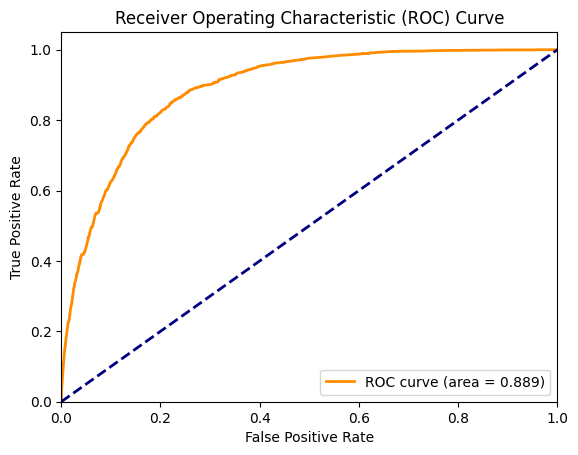

In [13]:
cb_best_params.update({'verbose': 0})
cb_model = CatBoostClassifier(**cb_best_params)
cb_model.fit(X_train_fe, y_train)

# Predict on the testing data
cb_y_pred = cb_model.predict(X_val_fe)
cb_y_pred_proba = cb_model.predict_proba(X_val_fe)[:, 1]

manual_auc_roc_draw(y_val, cb_y_pred_proba)

## Feature Importance

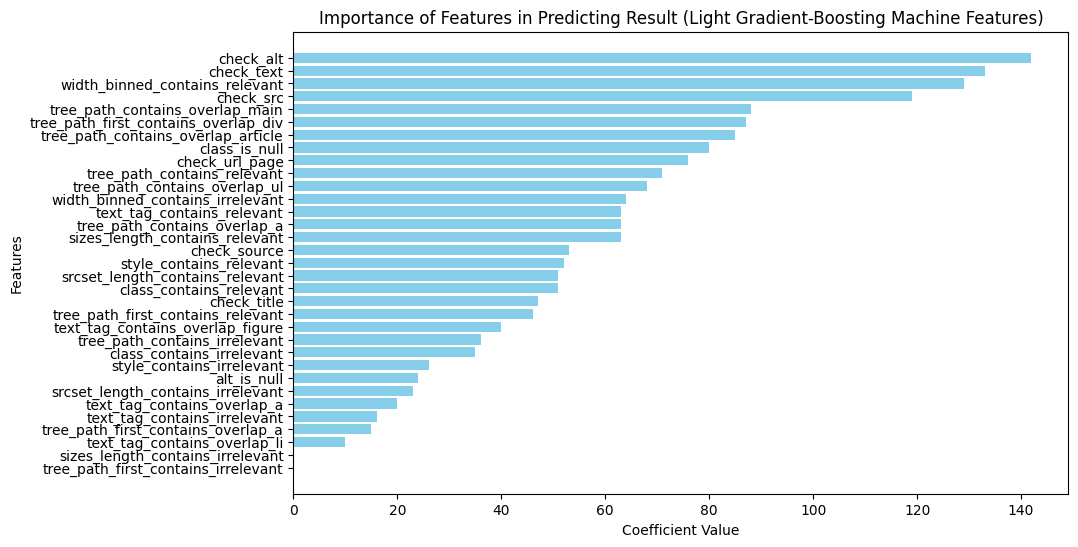

In [14]:
# For LGBM Model

col = X_train_fe.columns
coef = lgbm_model.feature_importances_
model_name = "Light Gradient-Boosting Machine"
feature_importance(col, coef, model_name)

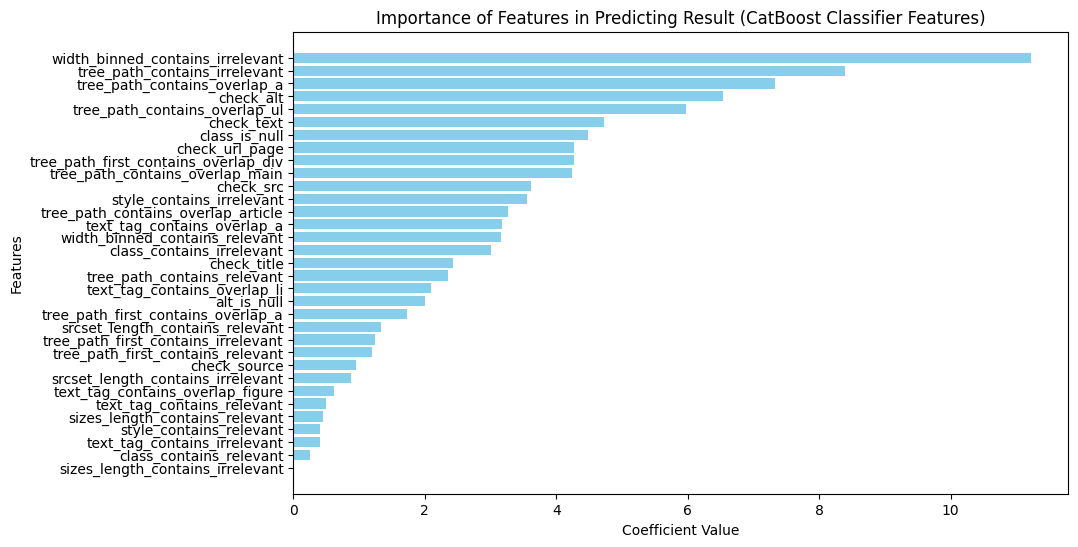

In [15]:
# For CatBoost Classifier Model

col = X_train_fe.columns
coef = cb_model.feature_importances_
model_name = "CatBoost Classifier"
feature_importance(col, coef, model_name)

## Retrained Model with All Training Data

### Feature Engineering

In [16]:
final_train_output = add_new_features(ori_train_df, 'train')
final_X_train_fe = final_train_output.pop(0)
test_inputs = final_train_output

null_check_columns:  ['alt', 'sizes', 'class']
columns_to_drop:  ['crossorigin', 'ismap', 'longdesc', 'referrerpolicy']
Successfully dropping fully Null columns!

Successfully indicating partially Null columns!

Successfully adding text-based features!

Successfully adding url-based features!

rel_feature_potential:  ['figure', 'p']
irrel_feature_potential:  ['a']
Total Data covered: 46.7%
Successfully adding first tree-path feature!

rel_feature_potential:  ['figure', 'p', 'strong', 'amp-img', 'details', 'readme-toc', 'pre', 'task-lists', 'textarea', 'app-layout', 'app-person', 'ps-carousel', 'tw-wrapper', 'object', 'app-project-detail', 'z-widget', 'devsite-content', 'bodyclass', 'flo-root', 'flo-header-layout', 'fontcolor', 'app', 'index', 'root', 'merchant-p0-info', 'merchant-detail', 'app-person-header', 'discovery', 'article-content-flex2019', 'tab-item', 'app-create-meme', 'single-item', 'lazy-hydrate', 'flo-collection', 'tab-list', 'hero-image', 'spand']
irrel_feature_potential

In [17]:
# Extract target label from original table
ori_y_train = ori_train_df.loc[:, train_df.columns.isin(['is_relevant'])]

In [18]:
# Load test data
test_file_path= 'data/test.feather'
ori_test_df = pd.read_feather(test_file_path)

In [19]:
final_test_output = add_new_features(ori_test_df, 'test', test_inputs)
final_X_test_fe = final_test_output.pop(0)

Successfully dropping fully Null columns!

Successfully indicating partially Null columns!

Successfully adding text-based features!

Successfully adding url-based features!

Successfully adding first tree-path feature!

Successfully adding overall tree-path feature!

Successfully adding text-tag feature!

Successfully adding height-based feature!

Successfully adding sizes-based feature!

Successfully adding srcset-based feature!

Successfully adding width-based feature!

Successfully adding class-based feature!

Successfully adding style-based feature!

Successfully removing high correlated features!

Successfully reordering columns!



### Model Training and Test Set Inference

In [20]:
# Model Training
final_lgbm_model = LGBMRanker(**lgbm_best_params)
ori_train_groups = ori_train_df.groupby('query').size().to_frame('size')['size'].to_numpy()
final_lgbm_model.fit(final_X_train_fe, ori_y_train, group=ori_train_groups)

# Model Inference
final_lgbm_y_pred_proba = final_lgbm_model.predict(final_X_test_fe)
proba_to_predict = lambda proba, threshold=0.5: (proba > threshold).astype(int)
final_lgbm_y_pred = proba_to_predict(final_lgbm_y_pred_proba)

/Users/jeffersonqiu/Desktop/Interviews/post_riot/ahrefs/ahrefs_env/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 64
[LightGBM] [Info] Number of data points in the train set: 607844, number of used features: 32


In [21]:
ori_test_df['is_relevant'] = final_lgbm_y_pred_proba

In [22]:
ori_test_df.sort_values(by=['query', 'is_relevant'], ascending=False, inplace=True)
submission_df = ori_test_df[['id', 'is_relevant']]

In [25]:
submission_df.to_csv('final_submission/submission.csv', index=False)